In [1]:
import numpy as np
import matplotlib.pyplot as plt

points = np.random.uniform(1,10, size=(100000,24))
points.shape

(100000, 24)

In [152]:
def fps(points, n_samples):
    """
    points: [N, 3] array containing the whole point cloud
    n_samples: samples you want in the sampled point cloud typically << N 
    """
    points = np.array(points)
    
    # Represent the points by their indices in points
    points_left = np.arange(len(points)) # [P]

    # Initialise an array for the sampled indices
    sample_inds = np.zeros(n_samples, dtype='int') # [S]'

    # Initialise distances to inf
    dists = np.ones_like(points_left) * float('inf') # [P]

    # Select a point from points by its index, save it
    selected = 0
    sample_inds[0] = points_left[selected]

    # Delete selected 
    points_left = np.delete(points_left, selected) # [P - 1]

    # Iteratively select points for a maximum of n_samples
    for i in range(1, n_samples):
        # Find the distance to the last added point in selected
        # and all the others
        last_added = sample_inds[i-1]
        
        dist_to_last_added_point = (
            (points[last_added] - points[points_left])).sum(-1) # [P - i]

        # If closer, updated distances
        dists[points_left] = np.minimum(dist_to_last_added_point, 
                                        dists[points_left]) # [P - i]

        # We want to pick the one that has the largest nearest neighbour
        # distance to the sampled points
        selected = np.argmax(dists[points_left])
        sample_inds[i] = points_left[selected]

        # Update points_left
        points_left = np.delete(points_left, selected)

    return points[sample_inds]


In [3]:
fps_points = fps(points, 100)

In [4]:
fps_points.shape

(100, 24)

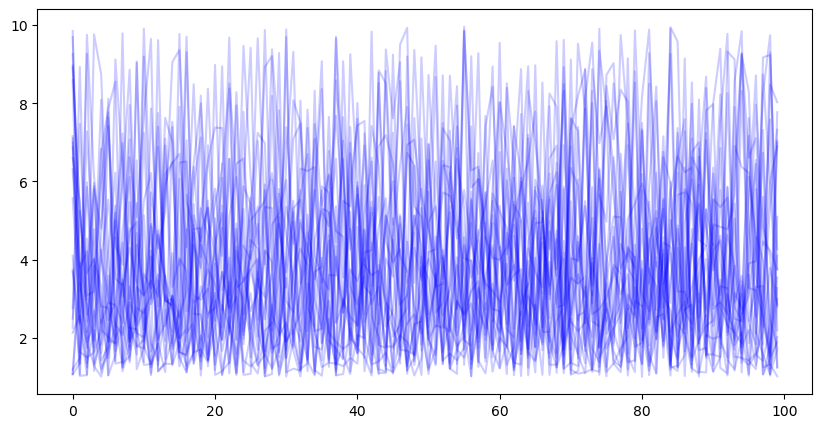

In [5]:
plt.figure(figsize=(10,5))
plt.plot(fps_points, alpha = 0.2, color = "b")

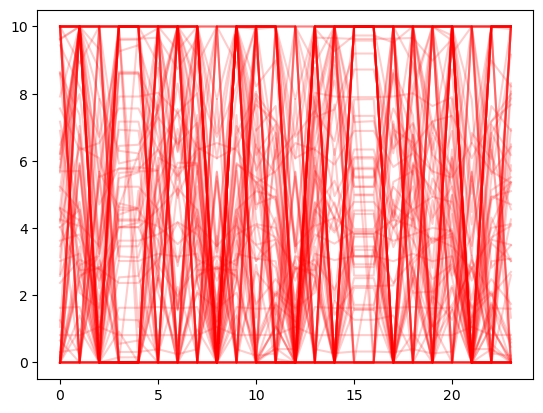

In [123]:
import scipy

K =100
dim = 24
sampled_points = [np.random.randint(0,10, size = dim)]
for k in range(K):
    def dist(x,z):
        return np.linalg.norm(x-z, ord=2)

    def objective(z):
        return -np.min([dist(z,x) for x in sampled_points])
    bnds = [(0,10) for i in range(dim)]

    sample = scipy.optimize.minimize(objective, x0 = np.zeros(dim),  method = "L-BFGS-B", bounds=bnds)
    sampled_points.append(sample.x)
    plt.plot(sample.x, alpha = 0.2, color = "r")


(0.0, 10.0)

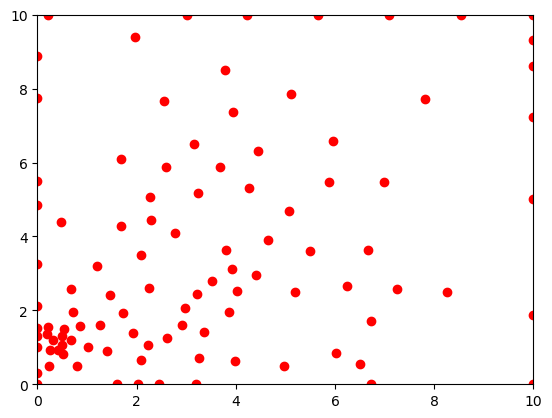

In [122]:
data = np.asarray(sampled_points)
plt.scatter(data[:,0], data[:,1], color = "r")
plt.xlim(0,10)
plt.ylim(0,10)

In [ ]:
def greedy_sampling(origin_vector, n_samples, bounds):
    K = n_samples
    dim = len(origin_vector)
    sampled_points = [origin_vector]
    for k in range(K):
        def dist(x,z):
            return np.linalg.norm(x-z, ord=2)

        def objective(z):
            return -np.min([dist(z,x) for x in sampled_points])
        bnds = [(0,bounds[i]) for i in range(dim)]

        sample = scipy.optimize.minimize(objective, x0 = np.zeros(dim),  method = "L-BFGS-B", bounds=bnds)
        sampled_points.append(sample.x)
    return np.asarray(sampled_points)

In [3]:
import docplex.mp.model as cpx
import numpy as np
import matplotlib.pyplot as plt

"""[1] B. Estermann, “Deep Learning-Powered Iterative Combinatorial Auctions with Active Learning,” 2023.

"""

def get_max_dist_bundle (origin_sample, other_samples, bounds):
    M = 100000
    mdl = cpx.Model()
    prin
    dim = len(origin_sample)
    n_samples = len(other_samples) +1 
    other_samples = list(other_samples)
    t = mdl.continuous_var_matrix(n_samples,dim , lb=0, ub=np.inf)
    bin = mdl.binary_var_matrix(n_samples, dim)
    x = mdl.continuous_var_list(dim, lb=0, ub=bounds)
    objective  = mdl.sum([t[(0,i)] for i in range(dim)])
    for k in range(n_samples):
        for i in range(dim):
            if k == 0 :
                mdl.add_constraint(x[i]-origin_sample[i] + M * bin[(k,i)] >= t[(k,i)])
                mdl.add_constraint(- x[i] + origin_sample[i] + M * (1-bin[(k,i)]) >= t[(k,i)])
                mdl.add_constraint(x[i]-origin_sample[i] <= t[(k,i)])
                mdl.add_constraint(-x[i] + origin_sample[i] <= t[(k,i)])
            else:
                mdl.add_constraint(x[i]-other_samples[k-1][i] + M * bin[(k,i)] >= t[(k,i)])
                mdl.add_constraint(- x[i] +other_samples[k-1][i] + M * (1-bin[(k,i)]) >= t[(k,i)])
                mdl.add_constraint(x[i]- other_samples[k-1][i] <= t[(k,i)])
                mdl.add_constraint(-x[i] +other_samples[k-1][i] <= t[(k,i)])               

    for k in range(len(other_samples)):
        mdl.add_constraint(objective <=mdl.sum([t[(k,i)] for i in range(dim)]))    

    mdl.maximize(objective)
    
    mdl.solve()
    
    return tuple(x[i].solution_value for i in range(len(origin_sample))), objective.solution_value


def GALI_sampling ( origin_vector, n_samples, bounds): 
    S = {origin_vector}

    for n in range(n_samples):
        max_value, max_bundle = 0,None      
        for origin_sample in S:
            bundle, value = get_max_dist_bundle(origin_sample,S - {origin_sample}, bounds)
            if value > max_value:
                max_value = value
                max_bundle = bundle
        S.add(max_bundle)

    return S


        

data = GALI_sampling(tuple((0 for i in range(2))), 10, [10 for i in range(2)])

TypeError: 'int' object is not subscriptable

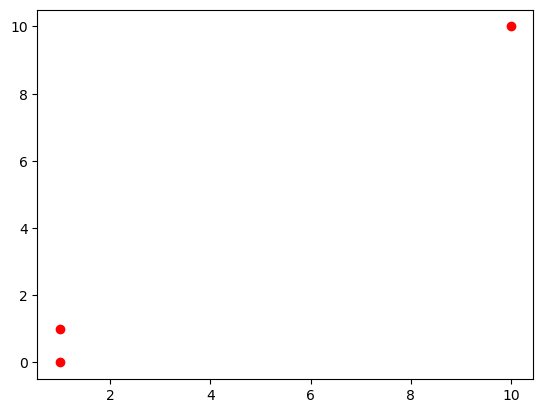

In [91]:
plt.scatter(x=[x[0] for x in data], y=[x[1] for x in data], color = "r")

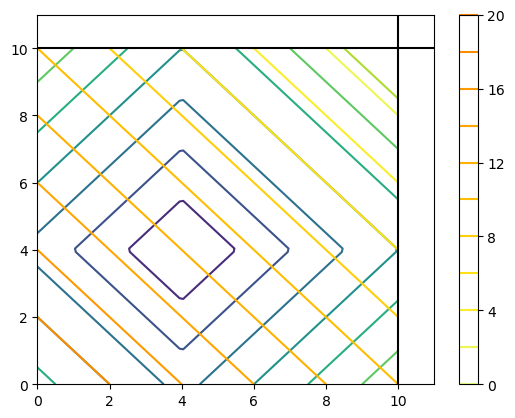

In [87]:
x = np.linspace(0,10,100)
y = np.linspace(0,10,100)
X, Y = np.meshgrid(x, y)
s_0 = (4,4)
s_1 = (10,10)
Z = abs(X-s_0[0]) + abs(Y-s_0[1])
Z1 = abs(X-s_1[0]) + abs(Y-s_1[1])
plt.contour(X, Y, Z, levels = 10)
plt.contour(X, Y, Z1, levels = 10, cmap = "Wistia")
plt.xlim(0,11)
plt.ylim(0,11)
plt.axhline(10, color='black')
plt.axvline(10, color='black')
plt.colorbar()

In [18]:
import numpy as np
conso = [1.3486959329357744, 1.0877501067919773, 1.046067294300736, 1.0232273970452614, 1.5571099953919798, 2.6484764192494072, 3.933410972346981, 3.5573139975401666, 2.473751205245027, 1.7327868717820054, 0.9368164524287159, 0.8958949698459905, 0.7824568134771335, 0.6187708831462322, 0.59003067909976, 0.9724086256518305, 3.667135836843573, 6.2882043793864115, 6.862627795361598, 6.662207696944807, 6.585503708661839, 5.288578209505141, 3.6762717957457633, 2.406944505772763]
print(np.asarray(conso).sum())
def uniform_devroye_sampling(n_samples, bounds):
    dim = len(bounds)
    samples = []
    rejected_samples = []
    while len(samples) < n_samples:

        U = np.random.uniform(0,1, dim+1)
        U[0] = 0 
        U.sort()

        X = U[1:] - U[:-1]
        X = X * bounds  
        if np.any(X > np.asarray(conso[:dim])+3) or X.sum()< 1 :
            rejected_samples.append(X)
        else: 
            print(len(samples))
            samples.append(X)


    return samples, rejected_samples

66.64244254450088


In [19]:
dim = 24

bound = [conso[i]*dim*1 for i in range(dim)]

data, rejected_data= uniform_devroye_sampling(1000, bound)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

66.64244254450087


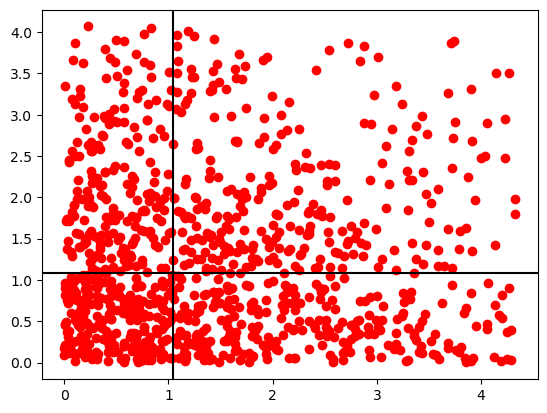

In [20]:
import matplotlib.pyplot as plt
plt.scatter(x=[x[0] for x in data], y=[x[1] for x in data], color = "r")
# plt.scatter(x=[x[0] for x in rejected_data], y=[x[1] for x in rejected_data], color = "b")
plt.axhline(conso[1], color='black')
plt.axvline(conso[2], color='black')
print(sum(conso[:dim]))

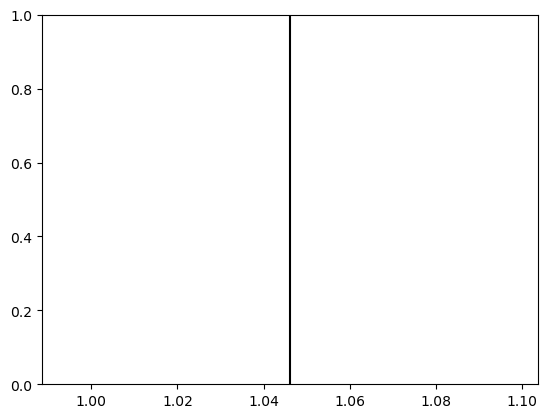

In [21]:
import matplotlib.pyplot as plt
# plt.scatter(x=[x[0] for x in data], y=[x[1] for x in data],c= [x[2] for x in data])
# plt.scatter(x=[x[0] for x in rejected_data], y=[x[1] for x in rejected_data], color = "b")plt.axhline(conso[1], color='black')

plt.axvline(conso[2], color='black')

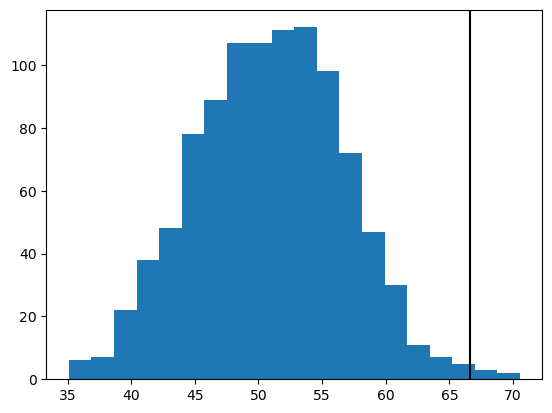

50.946005933189994

In [22]:
plt.hist(np.asarray(data).sum(axis = 1), bins = 20)
plt.axvline(np.asarray(conso[:dim]).sum(), color='black')
plt.show()
np.asarray(data).sum(axis = 1).mean()


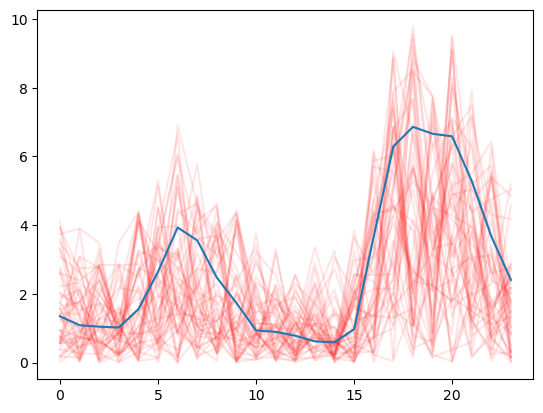

In [23]:
for i in data[:50] : 
    plt.plot(i, alpha = 0.1, color = "r")
plt.plot(conso[:dim])

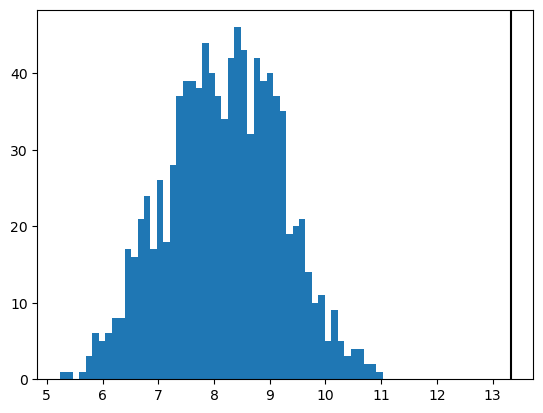

In [24]:
def calculate_value(bundle, conso):
    return np.minimum(np.asarray(bundle), conso[:dim]).sum()*0.2

res = []
for i in data : 
    res.append(calculate_value(i, conso))

plt.hist(res, bins = 50)
plt.axvline(np.asarray(conso[:dim]).sum()*0.2, color='black')

In [25]:
def uniform_sampling(n_samples, bounds):
    dim = len(bounds)
    samples = []
    for i in range(n_samples):
        X = np.random.uniform(0,1, dim) * bounds
        samples.append(X)
    return samples

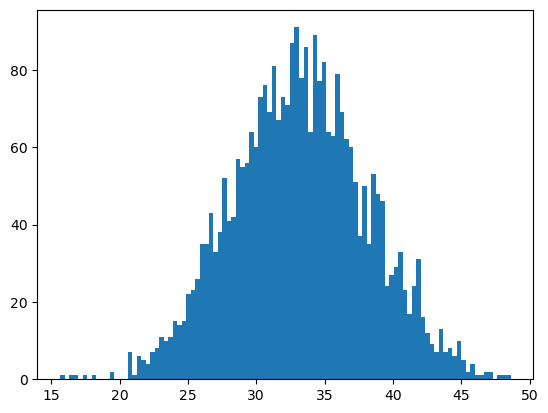

33.22358332954746

In [26]:
data = uniform_sampling(3000, conso)
plt.hist(np.asarray(data).sum(axis = 1), bins = 100)
plt.show()
np.asarray(data).sum(axis = 1).mean()

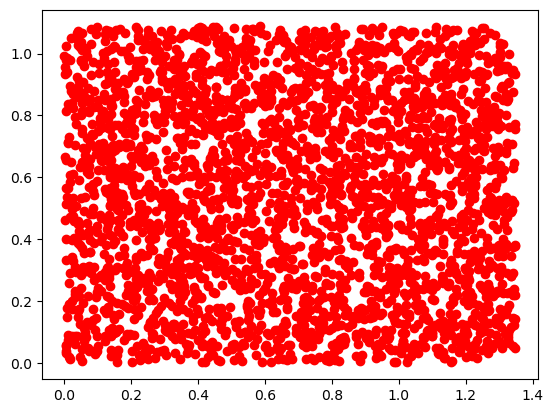

In [27]:
import matplotlib.pyplot as plt
plt.scatter(x=[x[0] for x in data], y=[x[1] for x in data], color = "r")

# Metropolis HAstings


import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
% matplotlib inline
% matplotlib notebook
import ipywidgets as widgets
from IPython.display import display

In [202]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook
import ipywidgets as widgets
from IPython.display import display

In [236]:
def pi(x,V):
    '''
    Density of the target distribution, up to a constant. 
    
    x -- np array of size k
    V -- np array of size k*k
    '''
    if np.any(x > 8) or np.any(x < 0) or np.linalg.norm(x, ord =1) < 50 or np.linalg.norm(x, ord = 1) > 67:
        return 0
    return np.linalg.norm(x, ord = 1) 
    dist = x - np.asarray(conso[:dim]) 
    lambd = 0.4
    # return lambd* np.exp(-lambd * np.linalg.norm(dist, ord = 1))
    return np.exp(-np.linalg.norm(x))

In [237]:
def prop(x):
    '''
    Random proposition for the Metropolis-Hastings algorithm.
    Uses the Random Walk Metropolis formula with unit variance.
    
    x -- np array of size k
    '''
    return (x + normal(size=len(x))).astype(int)

In [238]:
def q(x,y):
    '''
    Probability density of transition x to y, up to a constant.
    Uses the Random Walk Metropolis formula with unit variance.
    
    x -- np array of size k
    y -- np array of size k
    '''
    dist = x-y
    return np.exp(-.5*np.dot(dist,dist))

In [239]:
example_V = np.array([[5.,4.5],[4.5,5.]])
example_V = np.abs(np.random.random((24,24)))
display(example_V)
display(np.linalg.inv(example_V))

array([[0.50121133, 0.45541516, 0.17193861, 0.31780279, 0.73752123,
        0.62025709, 0.96555275, 0.18482399, 0.90138299, 0.27221693,
        0.81549496, 0.63742822, 0.93435149, 0.59099478, 0.23835063,
        0.88984399, 0.79548042, 0.13474109, 0.98609524, 0.68640046,
        0.20953952, 0.63004651, 0.74418602, 0.53346399],
       [0.44643941, 0.74027068, 0.89875925, 0.13044301, 0.8452689 ,
        0.9728617 , 0.32015921, 0.69135073, 0.47616673, 0.80462794,
        0.17977525, 0.8667676 , 0.31541248, 0.08428285, 0.50816064,
        0.86656152, 0.51047446, 0.01484919, 0.92905761, 0.70695855,
        0.50881298, 0.76174513, 0.55033591, 0.44654496],
       [0.42840149, 0.45171415, 0.99627256, 0.67535272, 0.80759157,
        0.33416636, 0.69788739, 0.55297051, 0.38602048, 0.45842009,
        0.35595438, 0.85498905, 0.83856033, 0.10404723, 0.20881946,
        0.66973078, 0.78461096, 0.68701405, 0.92605984, 0.69407321,
        0.07506155, 0.8654838 , 0.48419952, 0.54678529],
       [0.654

array([[ 8.68210427e-02, -1.16841010e-01, -4.11277153e-01,
        -4.72841259e-01,  5.76003474e-02, -1.94242970e-01,
        -1.46380424e-01,  1.55343704e-01,  6.77565937e-01,
        -3.90765442e-01,  1.90762726e-01,  7.86314389e-01,
         3.12332468e-01,  1.11143969e+00, -3.78779533e-01,
        -6.91976987e-01,  9.35402528e-02,  4.41298028e-01,
         4.93915848e-01, -1.27446969e+00, -6.03447816e-01,
         8.78943406e-01,  1.23969658e-01, -9.41554374e-02],
       [-4.55247349e-01,  2.96251724e-01, -1.10763276e+00,
        -7.98068264e-01, -7.42367385e-01, -3.56192173e-01,
        -4.85142886e-01, -1.91023401e-01,  6.14374330e-01,
        -1.44546597e-01,  2.56585817e-01, -1.13505426e+00,
         1.81336406e-01,  1.67775746e+00,  2.72050620e-01,
         3.08338992e-01,  1.30175864e+00, -5.00633914e-01,
         4.71534044e-02, -5.58862364e-01,  3.53314898e-01,
         4.18073118e-01,  8.66801038e-01,  2.41267929e-01],
       [-4.24393781e-01, -1.18720059e-01,  9.68423871e

In [240]:
np.linalg.inv(example_V)[1,0]/np.linalg.inv(example_V)[0,0]

-5.243513956203458

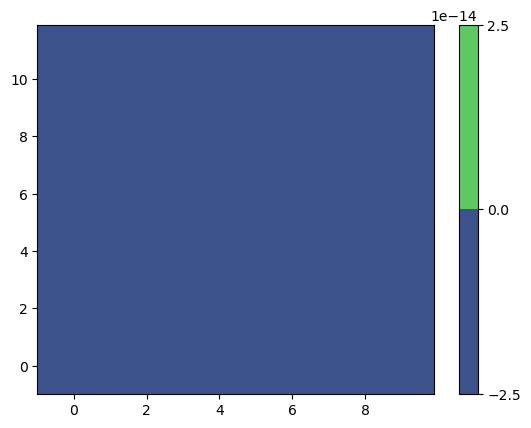

In [241]:
x = np.arange(-1.0, 10.0, 0.1)
y = np.arange(-1.0, 12.0, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.array([[pi(np.array([X[i,j],Y[i,j]]),V=example_V) for j in range(len(X[0]))] for i in range(len(X))])
fig1 = plt.figure()
CS = plt.contourf(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10);
plt.colorbar()

In [242]:
def MH(N,pi,q,prop,x0,V=np.identity(2)):
    x = x0
    trajectory = [x0]
    for i in range(1,N):
        y = prop(x)
        ratio = pi(y,V)*q(x,y)/pi(x,V)/q(y,x)
        a = np.min([1.,ratio])
        r = np.random.rand()
        if r < a:
            x = y
        trajectory += [x]
    return np.array(trajectory)

In [243]:
dim =24
print(conso[:dim],np.sum(conso[:dim]))
traj = MH(100000,pi,q,prop,x0 = np.asarray(conso[:dim])+0.0001,V=example_V)


[1.3486959329357744, 1.0877501067919773, 1.046067294300736, 1.0232273970452614, 1.5571099953919798, 2.6484764192494072, 3.933410972346981, 3.5573139975401666, 2.473751205245027, 1.7327868717820054, 0.9368164524287159, 0.8958949698459905, 0.7824568134771335, 0.6187708831462322, 0.59003067909976, 0.9724086256518305, 3.667135836843573, 6.2882043793864115, 6.862627795361598, 6.662207696944807, 6.585503708661839, 5.288578209505141, 3.6762717957457633, 2.406944505772763] 66.64244254450088


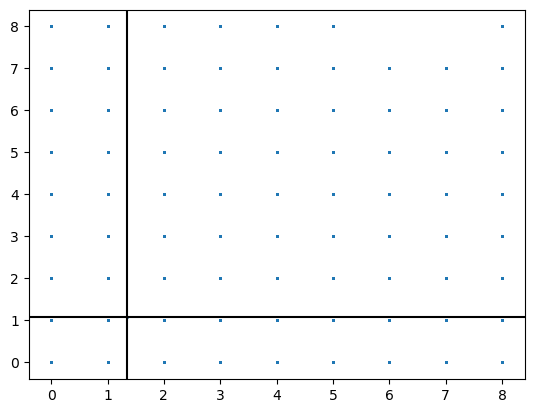

In [244]:
%matplotlib inline
plt.scatter(traj[:,0],traj[:,1],s=1)
plt.axvline(conso[0], color='black')
plt.axhline(conso[1], color='black')
plt.show()

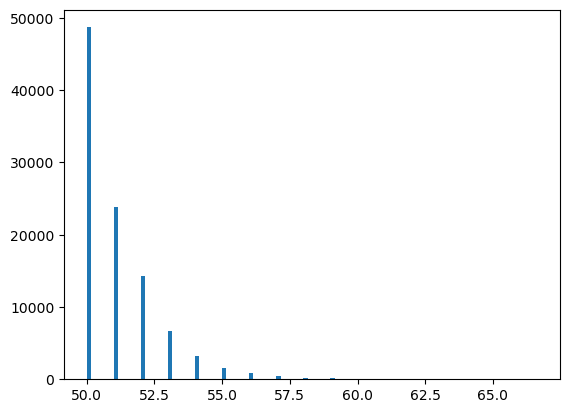

In [249]:
plt.hist(traj.sum(axis=1), bins =100)

plt.show()

In [250]:
def value_function(x):

    return np.minimum(x, conso[:dim]).sum()*0.2

In [251]:
res = np.apply_along_axis(value_function, 1, traj)

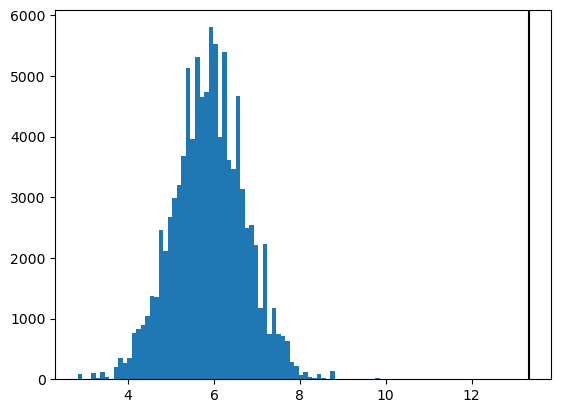

In [252]:
plt.hist(res, bins=100)
plt.axvline(value_function(conso[:dim]), color='black')
plt.show()

In [253]:
# random choose

idx = np.random.choice(np.arange(len(traj)), size = 10, replace = False)
samples = traj[idx]

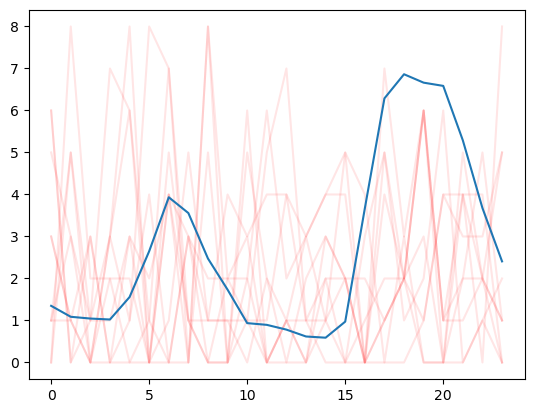

In [254]:
samples = np.asarray(samples)
for sample in samples[:50]:
    plt.plot(sample, alpha = 0.1, color = "r")
plt.plot(conso[:dim])

In [255]:
data_fps= fps(traj[10000: ], 100)

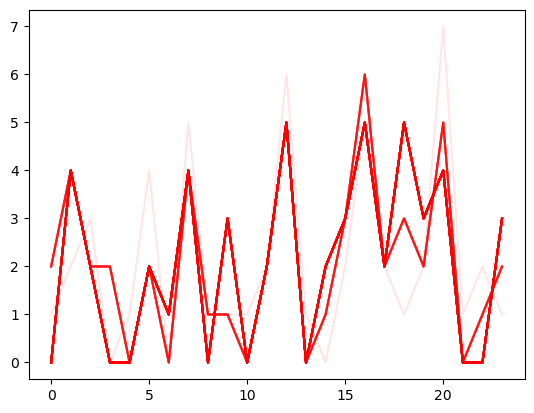

In [256]:
for sample in data_fps[:1000]:
    plt.plot(sample, alpha = 0.1, color = "r")

In [181]:
data_fps

array([[3.80423689, 0.93468385, 3.32133268, ..., 0.11282154, 1.11834748,
        0.20291124],
       [1.06748241, 2.8224989 , 3.22788296, ..., 1.42532095, 2.72138671,
        2.02565077],
       [1.06748241, 2.8224989 , 3.22788296, ..., 1.42532095, 2.72138671,
        2.02565077],
       ...,
       [6.73983781, 3.85556612, 0.17955597, ..., 5.5628508 , 0.62768909,
        4.62103462],
       [6.73983781, 3.85556612, 0.17955597, ..., 5.5628508 , 0.62768909,
        4.62103462],
       [6.73983781, 3.85556612, 0.17955597, ..., 5.5628508 , 0.62768909,
        4.62103462]])